In [1]:
import sys

sys.path.append("..")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mango.mango import Mango
from mango.utils import plot_loss_reward
from mango.environments import frozen_lake
from mango.actions import grid2d

In [3]:
gamma = 0.8

init_kwargs = dict(map_name="RANDOM", shape=(16, 16), p=0.5, goal_pos=None, start_pos=None)
env = frozen_lake.CustomFrozenLakeEnv(**init_kwargs)  # type: ignore
env = frozen_lake.ReInitOnReset(env, **init_kwargs)
env = frozen_lake.TensorObservation(env, one_hot=True)
env_shape = (env.unwrapped.ncol, env.unwrapped.nrow)  # type: ignore

mango = Mango(
    environment=env,
    abstract_actions=[
        grid2d.SubGridMovementOnehot(cell_shape=(2, 2), grid_shape=env_shape, reward=(1 - gamma)),
        grid2d.SubGridMovementOnehot(cell_shape=(4, 4), grid_shape=env_shape, reward=(1 - gamma)),
    ],
    policy_params=dict(
        lr=1e-2,
        gamma=gamma,
        net_params=dict(
            hidden_channels=[8, 8],
            hidden_features=[],
            activation_out=torch.nn.Tanh(),
            device=torch.device("cuda") if torch.cuda.is_available() else None,
        ),
    ),
)

c:\Users\dsart\anaconda3\envs\python310base\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
c:\Users\dsart\anaconda3\envs\python310base\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


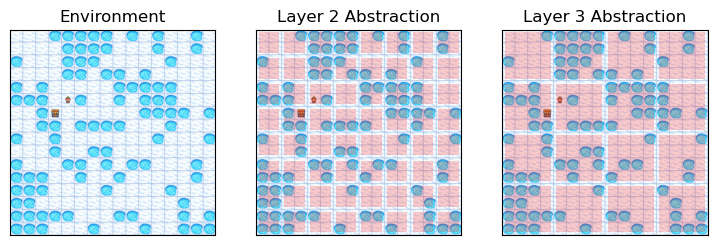

In [4]:
frozen_lake.plot_all_abstractions(mango)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

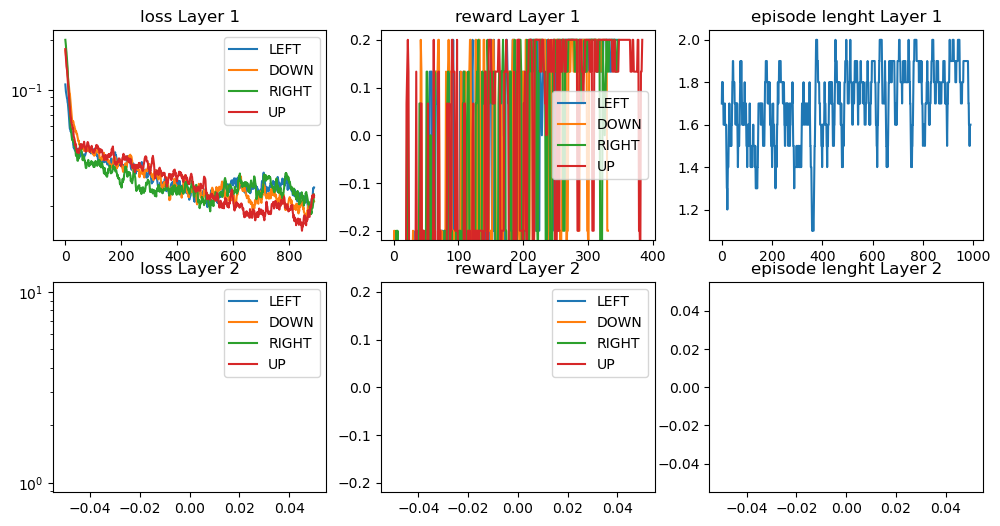

  0%|          | 0/1000 [00:00<?, ?it/s]

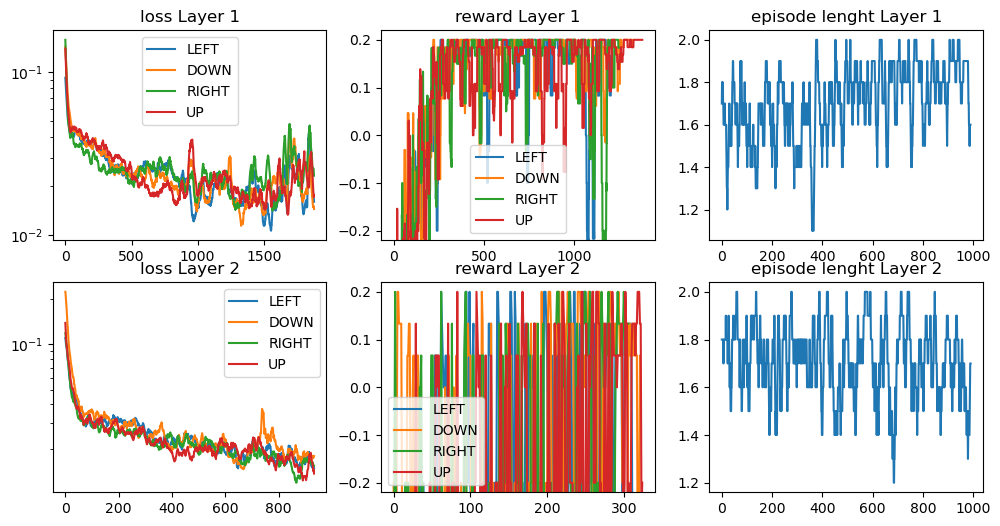

In [5]:
N = 1000
for layer in [1,2]:
    for randomness in (pbar := tqdm(np.linspace(1.0, 0.0, N))):
        pbar.set_description(f"randomness: {randomness:.3f}")
        mango.set_randomness(randomness, layer=layer)
        obs, reward, term, trunc, info = mango.explore(layer=layer, episode_length=2)
        mango.train()
    plot_loss_reward(mango, grid2d.Actions, layers=range(1,layer+1), reward_lims=(1.1*(gamma-1), 1.1*(1-gamma)))
    plt.show()
mango.save_to("trained_models/frozen_lake_mango.pickle")

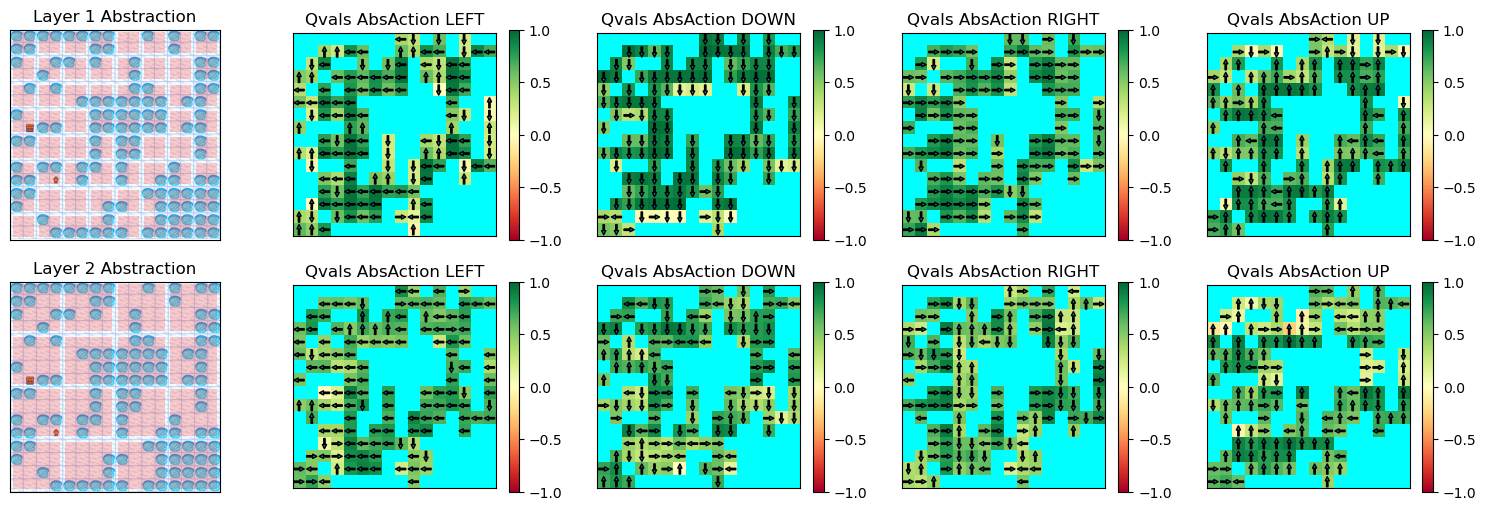

LEFT


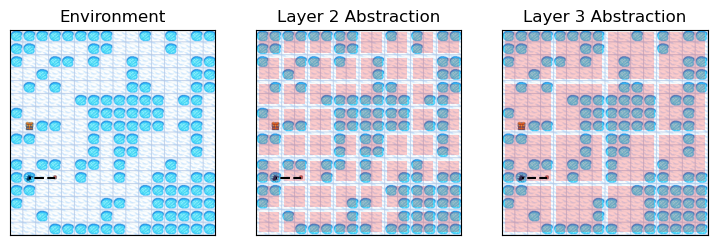

DOWN


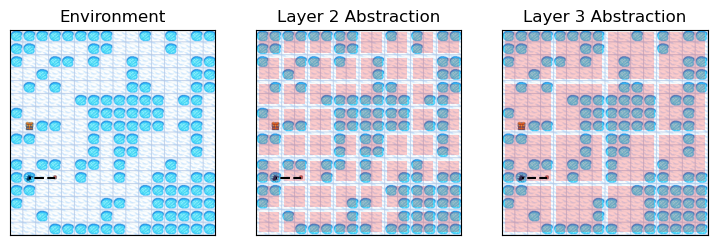

RIGHT


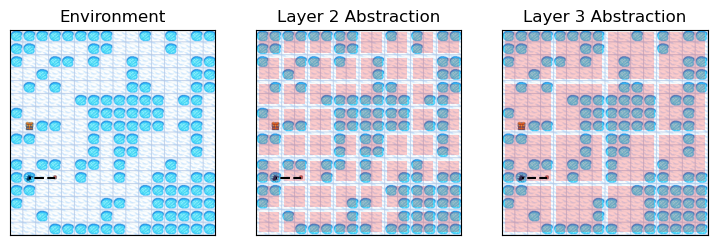

UP


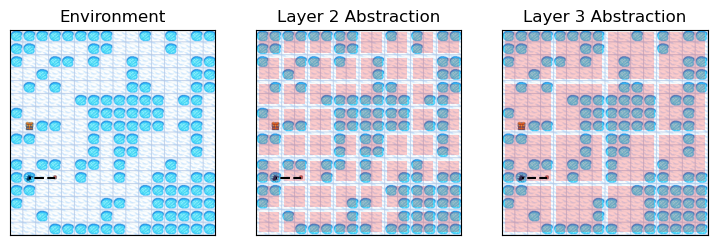

In [6]:
obs, info = mango.reset()
frozen_lake.plot_all_qvals(mango)
plt.show()

trajectory = [obs]
for action in grid2d.Actions:
    print(action.name)
    for step in range(10):
        obs, reward, trunc, term, info = mango.step((-1, action.value))
        trajectory.extend(info["mango:trajectory"])
        if not info["mango:truncated"]:
            break
    frozen_lake.plot_all_abstractions(mango, trajectory)
    plt.show()